# Local Volatility Model
------------------
> **Idriss Afra**

This project aims to strip the Equity Local Volatility surface and implement the associated Monte-Carlo pricing method.

## Model Description
The Local Volatility model assumes the following SDE under the risk-neutral measure :   

$$
dS_t = (r_t - q_t) \times S_t \times dt + \sigma(t, S_t) \times S_t \times dW_t
$$

Where $S_t$ is the stock or index price, $r_t$ is the deterministic instantaneous forward interest rate, $q_t$ is the deterministic instantaneous forward dividend yield, $\sigma(t, S_t)$ is the deterministic local volatility function, and $W_t$ is a standard brownian motion.

The price of a European call option $C(T, K)$ satisfies the following forward Kolmogorov PDE:    

$$
\frac{dC}{dT} + \left(r_T - q_T\right)K\frac{dC}{dK}-\frac{1}{2}\sigma^2(T, K)K^2\frac{d^2C}{dK^2} + q_TC = 0
$$

From this, we derive the Dupire equation:     
$$
\sigma^2(T, K) = 2\times\frac{\frac{dC}{dT} + \left(r_T - q_T\right)K\frac{dC}{dK} + q_TC}{K^2\frac{d^2C}{dK^2}}
$$

By applying the chain rule, we obtain the stripping formula used to calibrate the local volatility surface from the implied total variance surface:
$$
\sigma^2(t=T, S_t=K) = \frac{\frac{d\omega}{dT}}{1 - \frac{k}{\omega} \frac{d\omega}{dk} + \frac{1}{2} \frac{d^{2}\omega}{dk^{2}} + \frac{1}{4} \left( -\frac{1}{4} -\frac{1}{\omega} + \frac{k^{2}}{\omega} \right) \left( \frac{d\omega}{dk} \right)^{2} }
$$
Where $\omega(T, k)$ is the implied total variance, expressed as a function of time to maturity $T$ and log-moneyness $k=log\left(\frac{K}{F_T}\right)$, with $F_T$ being the forward price at time $T$.

Unlike the Black-Scholes model, which assumes constant volatility, the Local Volatility model allows volatility to vary with both time and the underlying asset’s price. This leads to a more realistic framework and enables enhanced replication of observed market option prices via the above stripping formula.
<br>However, the model presents some limitations. In particular, the stripped local volatility surface tends to flatten for long maturities, largely due to the illiquidity of long-dated options. As a result, the Local Volatility model is less suitable for pricing long-term or forward-starting derivatives. Additionally, the Greeks (i.e., sensitivity measures) derived from the Local Volatility model have been shown to be less accurate, reducing the model’s effectiveness in risk management applications.

### The Implied Total Variance

To extract the Local Volatility surface, we first need to compute the partial derivatives of the implied total variance $\omega(T, k)$ with respect to maturity and log-moneyness. This requires constructing a continuous, smooth, and arbitrage-free total variance function from the market listed options.
<br>In this project, we adopt the Stochastic Volatility Inspired (SVI) parameterization, a widely-used and flexible model that enables a stable fit to implied volatility skews across maturities. Additionally, the SVI approach facilitates the correction of potential Butterfly and Calendar arbitrages, which, if left unaddressed, can result in irregularities such as spikes or negative values in the stripped local volatility surface.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (11,8)

class svi_model:
    """
    SVI model.
    """
    def __init__(self, expiries, a, b, rho, m, sigma):
        """
        The parameters are given as dictionnaries, with the provided SVI expiries as keys. 
        """
        self.expiries = expiries
        self.a = a
        self.b = b
        self.rho = rho
        self.m = m
        self.sigma = sigma
        print("The SVI model class was successfully initialized !")
        
    def svi_v2T(self, T, k) :
        """
        V2T formula under the SVI model.
        The log-moneyness k can be a scalar or an array.
        """
        if T not in self.expiries : return sys.exit("The given expiry " + str(T) + \
                                                    " is not part of the provided SVI expiries.")
        return self.a[T] + self.b[T] * (self.rho[T] * (k - self.m[T]) + np.sqrt((k - self.m[T])**2 + self.sigma[T] **2))

    def svi_vol(self, T, k) :
        """
        Vol formula under the SVI model.
        The log-moneyness k can be a scalar or an array.
        """
        return np.sqrt(self.svi_v2T(T, k) / T)
    
    def get_v2T(self, T, k, interp_meth='cubic', min_k=np.log(0.5), max_k=np.log(1.5)) :
        """
        V2T formula under the SVI model.
        Expiry T : interp_meth (Cubic by default) V2T interpolation & Flat V2T extrapolation.
        Log-moneyness k : SVI V2T formula within [50% - 150%] & Flat V2T extrapolation (To avoid the SVI linear
        """
        k = min(max_k, max(min_k, k))
        if (T <= self.expiries[0]) or (T >= self.expiries[-1]) or (T in self.expiries):
            T = min(self.expiries[-1], max(self.expiries[0], T))
            return self.svi_v2T(T, k)
        else:
            v2T_k = [self.svi_v2T(exp, k) for exp in self.expiries]
            return interp1d(self.expiries, v2T_k, kind=interp_meth)(T)
        
    def plot_svi_surface(self, min_k=np.log(0.7), max_k=np.log(1.3), min_T=0.5, n_interv=81) :
        """
        SVI plotter.
        """
        K = np.linspace(min_k, max_k, n_interv, endpoint=True)
        T = np.linspace(min_T, self.expiries[-1], n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                vols[t, k] = np.sqrt(self.get_v2T(T[t][k], K[t][k])) / T[t][k]

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        plt.title("Implied SVI Volatility Surface")
        plt.show()

### The Implied Forward Curve

The implied forward prices of the underlying asset are required to compute both the log-moneyness values and the drift term in its SDE.

In [2]:
from scipy.stats import norm

class forward_curve:
    """
    The implied forward curve class.
    """
    def __init__(self, S0, zc_rate, listed_expiries, implied_repos_and_divs):
        """
        Init method : It sets the repos + dividends.
        """
        self.S0 = S0
        self.zc_rate = zc_rate
        self.listed_expiries = listed_expiries
        self.implied_repos_and_divs = implied_repos_and_divs
        self.set_repo_div_func()
        print("The Forward Curve class was successfully initialized !")
    
    def set_repo_div_func(self):
        """
        Setter method of implied repos plus dividends, assuming they are piecewise constant between the market expiries.
        """
        # Dividend Yield function : Piece-Wise Interpolation / Flat Extrapolation
        self.repo_div_func = interp1d([0] + self.listed_expiries, list(self.implied_repos_and_divs.values()) + \
                            [list(self.implied_repos_and_divs.values())[-1]], kind='previous', fill_value="extrapolate")

    def calc_forward(self, exp):
        """
        Computes the forward up to exp, given the repo_div_func attribute.
        """
        expiries = [0] + self.listed_expiries + [exp]
        expiries = sorted(list(set(expiries)))
        expiries = expiries[:expiries.index(exp) + 1]
        cumul = 0
        for i in range(len(expiries) - 1):
            cumul += (expiries[i + 1] - expiries[i]) * self.repo_div_func(expiries[i])
        return self.S0 * np.exp(self.zc_rate(exp) * exp - cumul)

### The Stripping Algorithm

In [3]:
from scipy.interpolate import interp2d

import warnings
warnings.filterwarnings("ignore")

class lv_model :
    """
    Local Volatility model.
    """
    def __init__(self, forward_curve, svi_model, apply_vol_smoothness=False, min_moneyness = 0.6, max_moneyness = 1.4,
                 eps = 1e-04):
        """
        Init method :
        - The implied total variance is computed using the svi_model.
        - Local Volatility is stripped within the range defined by min_moneyness and max_moneyness, and between the first 
          and last expiries in the SVI calibration. Outside these bounds, the surface is held flat.
        - If apply_vol_smoothness is set to True, the Local Volatility surface is stripped over a grid, followed by the 
          application of 2D bilinear smoothing to enhance surface regularity.
        """
        self.forward_price = forward_curve.calc_forward
        self.implied_v2T = svi_model.get_v2T
        self.min_moneyness = min_moneyness
        self.max_moneyness = max_moneyness 
        self.eps = eps
        self.min_exp = svi_model.expiries[0]
        self.max_exp = svi_model.expiries[-1]
        self.apply_vol_smoothness = apply_vol_smoothness
        print("The Local Volatility model class was successfully initialized !")
        # Local Vol discrete grid stripping + 2D bilinear smoothing
        if self.apply_vol_smoothness:
            print("Stripping the Local Volatility over a grid with 2D bilinear smoothing ...")
            self.set_lv_grid()
            print("The Local Volatility grid was successfully constructed !")
        
    def get_local_vol(self, t, S, lv_floor = 0.01) :
        """
        Loval Volatility getter : LV(t, S), floored by 1% in case of stripping anomalies.
        """
        t = min(self.max_exp, max(self.min_exp, t))
        fwd = self.forward_price(t)
        S = min(self.max_moneyness * fwd, max(self.min_moneyness * fwd, S))
        k = np.log(S / fwd)
        lv = self.lv_grid(t, k)[0] if self.apply_vol_smoothness else self.dupire_func(t, k)
        if lv <= lv_floor : print("Local vol floored by " + str(lv_floor) + " at : (" \
                                  + str(t) + ", " + str(S) + "), due to implied arbitrages.")
        return max(lv, lv_floor)
        
    def _dv2T_dT(self, t, k, eps_t):
        """
        The partial derivative of the implied total variance v2T with respect to time to maturity T.
        /!\ For internal use only /!\
        """
        if t == self.min_exp:
            return (self.implied_v2T(t + eps_t, k) - self.implied_v2T(t, k)) / eps_t
        elif t == self.max_exp:
            return (self.implied_v2T(t, k) - self.implied_v2T(t - eps_t, k)) / eps_t
        else :
            return (self.implied_v2T(t + eps_t, k) - self.implied_v2T(t - eps_t, k)) / (2 * eps_t)
        
    def _dv2T_dk(self, t, k, eps_k):
        """
        The partial derivative of the implied total variance v2T with respect to log-moneyness k.
        /!\ For internal use only /!\
        """
        if k == np.log(self.min_moneyness):
            return (self.implied_v2T(t, k + eps_k) - self.implied_v2T(t, k)) / eps_k
        elif k == np.log(self.max_moneyness):
            return (self.implied_v2T(t, k) - self.implied_v2T(t, k - eps_k)) / eps_k
        else :
            return (self.implied_v2T(t, k + eps_k) - self.implied_v2T(t, k - eps_k)) / (2 * eps_k)
        
    def _d2v2T_dk2(self, t, k, eps_k):
        """
        The second order partial derivative of the implied total variance v2T with respect to log-moneyness k.
        /!\ For internal use only /!\
        """
        if k == np.log(self.min_moneyness):
            k += eps_k
        if k == np.log(self.max_moneyness):
            k -= eps_k
        return (self.implied_v2T(t, k + eps_k) + self.implied_v2T(t, k - eps_k) - 2 * self.implied_v2T(t, k)) / eps_k**2
    
    def dupire_func(self, t, k) :
        """
        The Local Volatility stripping using Dupire's V2T formula.
        """
        v2T = self.implied_v2T(t, k)
        v2T_inverse = 1. / v2T
        
        eps_t = self.eps * t
        dv2T_dT = self._dv2T_dT(t, k, eps_t)
        dv2T_dT = max(dv2T_dT , 0) # Floor dv2T_dT by 0 to limit the calendar arbitrage impact
        
        eps_k = self.eps * k
        dv2T_dk = self._dv2T_dk(t, k, eps_k) 
        d2v2T_dk2 = self._d2v2T_dk2(t, k, eps_k)
        d2v2T_dk2 = max(d2v2T_dk2 , 0) # Floor d2v2T_dk2 by 0 to limit the butterfly arbitrage impact
        
        num = dv2T_dT
        den = 1 - k * v2T_inverse * dv2T_dk + 0.5 * d2v2T_dk2 + 0.25 * (-0.25 - v2T_inverse + \
                                                                        v2T_inverse * k**2) * dv2T_dk**2
        return np.sqrt(num/den)

    def set_lv_grid(self, n_interv=61):
        """
        The Local Volatility grid, with 2D bilinear interpolation.
        """
        t_interp = np.linspace(self.min_exp, self.max_exp, n_interv, endpoint=True)
        k_interp = np.linspace(np.log(self.min_moneyness), np.log(self.max_moneyness), n_interv, endpoint=True)
        K, T = np.meshgrid(k_interp, t_interp)
        lv_grid = np.array([[self.dupire_func(T[t][k], K[t][k]) 
                                for k in range(n_interv)] for t in range(n_interv)])
        self.lv_grid = interp2d(T, K, lv_grid, kind='linear')

    def plot_lv_surface(self, min_k=np.log(0.6), max_k=np.log(1.4), min_T=0.5, n_interv=81):
        """
        LV plotter.
        """
        K = np.linspace(min_k, max_k, n_interv, endpoint=True)
        T = np.linspace(min_T, self.max_exp, n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        S = np.zeros(shape=K.shape)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                S[t, k] = np.exp(K[t][k]) * self.forward_price(T[t][k])
                vols[t, k] = self.get_local_vol(T[t][k], S[t, k])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(S, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        plt.title("Local Volatility Surface")
        plt.show()   

## The Monte-Carlo Local Volatility Pricer
Applying Euler’s scheme to the Local Volatility SDE of the spot price yields the following simulation equation:

$$
S_{t+dt} = S_{t} \times exp\left(\left(r_t - q_t - \frac{\sigma^2(t, S_t)}{2}\right) dt + \sigma(t, S_t) dW_t \right)
$$

In [4]:
# Set the rnd seed @ 0
np.random.seed(0)

class mc_lv_pricer :
    """
    The Monte-Carlo LV pricer class.
    """
    def __init__(self, zc_rate, forward_curve, svi_model, lv_model) :
        """
        Init method : Takes the discounting curve, forward curve, svi model, and the lv model.
        """
        self.zc_rate = zc_rate
        self.forward_price = forward_curve.calc_forward
        self.implied_v2T = svi_model.get_v2T
        self.local_vol = lv_model.get_local_vol
        self.S = np.array([])
        print("The Monte-Carlo LV pricer class was successfully initialized !")
        
    def set_path(self, T, n_simul=3*10**5, n_steps=100, n_stdev=8, n_interv=300) :
        """
        Setter method : Simulates and stores the spot price path of shape Nsteps x Nsimul.
        """
        # Generate random N(0,1)
        normal = np.random.normal(0, 1, (n_steps, n_simul))
        
        # Time vector
        dt = T / n_steps
        t = np.linspace(0, T, num=n_steps + 1, endpoint=True)
        sqrt_dt = np.sqrt(dt)
        
        # S array (time x simulations)
        self.S = np.empty(shape=(n_steps + 1, n_simul))
        self.S[0,:] = self.forward_price(0)
        
        prev_fwd = self.forward_price(0)
        
        for j in range(n_steps) :
            fwd = self.forward_price(t[j + 1])
            factor = np.exp(n_stdev * np.sqrt(self.implied_v2T(t[j], 0)))
            Smax = (max(self.S[j,:]) if j > 0 else self.S[0,0]) * factor
            Smin = (min(self.S[j,:]) if j > 0 else self.S[0,0]) / factor
            # Compute local vol interpolation
            Sinterp = np.linspace(Smin, Smax, num=n_interv + 1, endpoint=True)        
            local_vols = np.array([self.local_vol(t[j], s) for s in Sinterp])
            local_vol_interp = interp1d(Sinterp, local_vols, kind='cubic', fill_value="extrapolate")
            sigma = local_vol_interp(self.S[j,:]) # Interpolation on a discrete grid is much faster
            # The drift : r_t - q_t
            mu = np.log(fwd / prev_fwd) / dt
            prev_fwd = fwd
            # Spot simulations from t to t + dt
            self.S[j+1,:] = self.S[j,:] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * sqrt_dt * normal[j,:])

    def vanilla_price(self, T, K, isCall) :
        """
        The vanilla option MC price : DF x Mean(PayOff)
        """
        if self.S == np.array([]) : return sys.exit("The MC path should be constructed first through the set_path method.")
        df = np.exp(-self.zc_rate(T) * T)
        phi = 1 if isCall else -1
        payoff = np.maximum(phi * (self.S[-1,:] - K) , 0)
        return df * np.mean(payoff)

## Application : CAC40 Listed Index Options

Let's strip the local volatility of the French index CAC40. To achieve this, we use the CAC40 implied forwards and volatilities as of February 12, 2025, derived in the following project : [Equity Implied Volatility Surface](https://github.com/Idriss-Afra/Equity-Implied-Volatility-Surface/blob/main/Equity%20Implied%20Volatility%20Surface.ipynb).

In [5]:
import datetime
import pandas as pd
from scipy.interpolate import interp1d

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")

eq_underlying = "CAC40"
S0 = 8042.19
print(eq_underlying + " Close Price : ", S0)
print("-----------------------------------------------")

option_data = pd.read_csv("MarketData/" + eq_underlying + "_MarketData_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(eq_underlying + " Option Data :")
print(option_data)
print("-----------------------------------------------")

rate_underlying = "EURIBOR6M"
print(rate_underlying + " Zero-Coupon Rate Curve :")
rates_data = pd.read_csv("MarketData/" + rate_underlying +  "_ZCRates_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(rates_data)

# ZC Rate : Cubic Interpolation & Extrapolation
zc_rate = interp1d(rates_data['Expiry'], rates_data['ZCRate'], kind='cubic', fill_value="extrapolate")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Option Data :
       Expiry   Strike    Call      Put  Repo+Dividend      Forward  \
0    0.024658   7925.0  151.83    27.92      -0.007517  8048.999044   
1    0.024658   7950.0  132.52    33.59      -0.007517  8048.999044   
2    0.024658   7975.0  114.13    40.18      -0.007517  8048.999044   
3    0.024658   8000.0   96.79    47.82      -0.007517  8048.999044   
4    0.024658   8025.0   81.15    57.17      -0.007517  8048.999044   
..        ...      ...     ...      ...            ...          ...   
137  4.857534   8000.0  977.10  1115.35       0.026932  7847.492862   
138  4.857534   8400.0  808.07  1308.91       0.026932  7847.492862   
139  4.857534   8800.0  665.26  1528.71       0.026932  7847.492862   
140  4.857534   9600.0  450.36  2039.01       0.026932  7847.492862   
141  4.857534  10400.0  312.97  2626.83       

First, we gather the data and store it in global dictionaries:

In [6]:
def collect_data(option_data):
    """
    Collects market option data and store it in dictionaries.
    """
    implied_repos_and_divs, implied_forwards, strikes, call_prices, put_prices = dict(), dict(), dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        implied_repos_and_divs[exp] = float(np.unique(df['Repo+Dividend']))
        implied_forwards[exp] = float(np.unique(df['Forward']))
        df = df.sort_values(by=['Strike'])
        strikes[exp], call_prices[exp], put_prices[exp] = list(df['Strike']), list(df['Call']), list(df['Put'])
    return {"Repos+Dividends" : implied_repos_and_divs, "Forwards" : implied_forwards, "Strikes" : strikes,\
            "Call Prices" : call_prices, "Put Prices" : put_prices}  

# Collected Data
data = collect_data(option_data)
implied_repos_and_divs = data["Repos+Dividends"]
implied_forwards = data["Forwards"]
listed_expiries = list(implied_forwards.keys())
market_strikes = data["Strikes"]
call_prices = data["Call Prices"]
put_prices = data["Put Prices"] 

Next, we strip the Local Volatility surface for the CAC40 index. This is done using the SVI model, calibrated to CAC40 index options as of February 12, 2025, as detailed in the project: [Stochastic Volatility Inspired Model](https://github.com/Idriss-Afra/Stochastic-Volatility-Inspired-Model/blob/main/Stochastic%20Volatility%20Inspired%20Model.ipynb). During the calibration, we carefully addressed potential Butterfly arbitrage in the wings and Calendar Spread arbitrage across the full moneyness spectrum, ranging from $0.01\%$ to $200\%$.

CAC40 calibrated SVI parameters :
     Expiry         a         b       rho         m     sigma
0  0.024658  0.000359  0.004258 -0.990000  0.002237  0.017037
1  0.101370  0.001331  0.014232 -0.990000 -0.003540  0.046601
2  0.178082  0.001269  0.025889 -0.810728 -0.001629  0.086433
3  0.350685  0.004530  0.026990 -0.990000  0.024126  0.070899
4  0.600000  0.002058  0.061382 -0.482411  0.056843  0.143835
5  1.347945  0.005179  0.095272 -0.699682  0.053167  0.246532
6  1.846575  0.012462  0.112406 -0.523839  0.091100  0.270300
7  2.843836  0.008470  0.208197 -0.478105  0.050769  0.312906
8  3.841096  0.014743  0.266846 -0.445995  0.059171  0.319206
9  4.857534  0.024237  0.278673 -0.410327  0.106340  0.359709

The SVI model class was successfully initialized !


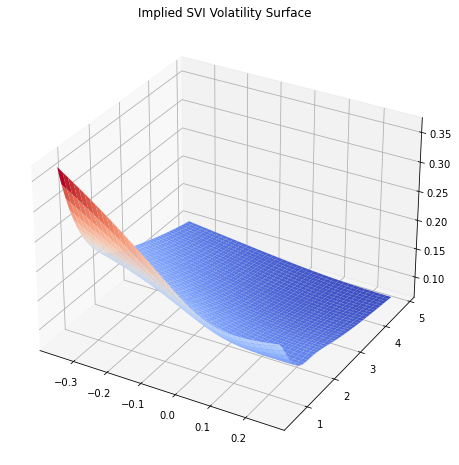

The Forward Curve class was successfully initialized !
The Local Volatility model class was successfully initialized !


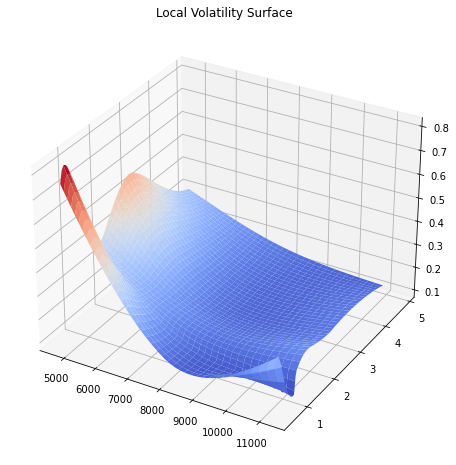

In [7]:
svi_params_df = pd.read_csv("MarketData/" + eq_underlying + "_SVI_" + as_of_date.strftime('%d%m%Y') + ".csv")
print(eq_underlying + " calibrated SVI parameters :")
print(svi_params_df)
print()

expiries = list(svi_params_df["Expiry"])
svi_expiries = []
i = 0
while i < len(expiries):
    exp = expiries[i]
    for listed_exp in listed_expiries:
        if abs(exp - listed_exp) < 1e-6:
            svi_expiries.append(listed_exp)
            break
    i += 1
    
a, b, rho, m, sigma = dict(), dict(), dict(), dict(), dict()
for i in range(len(svi_expiries)):
    a[svi_expiries[i]] = svi_params_df.iloc[i][1]
    b[svi_expiries[i]] = svi_params_df.iloc[i][2]
    rho[svi_expiries[i]] = svi_params_df.iloc[i][3]
    m[svi_expiries[i]] = svi_params_df.iloc[i][4]
    sigma[svi_expiries[i]] = svi_params_df.iloc[i][5]

# Implied Total Variance : SVI
svi_model = svi_model(svi_expiries, a, b, rho, m, sigma)
svi_model.plot_svi_surface()

# The Implied Forward Curve
forward_curve = forward_curve(S0, zc_rate, listed_expiries, implied_repos_and_divs)

# The stripped Local Volatility
lv_model_with_smoothness = lv_model(forward_curve, svi_model, apply_vol_smoothness=False)
lv_model_with_smoothness.plot_lv_surface()

Finally, We proceed to reprice the market vanilla options under the Monte-Carlo Local Volatility pricer and assess the accuracy of our calibration.
<br>We begin by filtering the market data to extract the prices of out-of-the-money call and put options:

In [8]:
def collect_otm_options():
    """
    Filters the listed options and collects the OTM ones.
    """
    otm_options = dict()
    for exp in listed_expiries:
        strikes_exp = market_strikes[exp]
        calls_exp = call_prices[exp]
        puts_exp = put_prices[exp]
        forward_exp = implied_forwards[exp]
        otm_options_exp = []
        for i in range(len(strikes_exp)):
            otm_options_exp.append(puts_exp[i] if strikes_exp[i] <= forward_exp else calls_exp[i])
        otm_options[exp] = otm_options_exp
    return otm_options

market_prices = collect_otm_options()
lv_model_no_smoothness = lv_model(forward_curve, svi_model, apply_vol_smoothness=False)
mc_pricer = mc_lv_pricer(zc_rate, forward_curve, svi_model, lv_model_no_smoothness)

The Local Volatility model class was successfully initialized !
The Monte-Carlo LV pricer class was successfully initialized !


Then, we compare the market option prices with those generated by the fitted Local Volatility model:

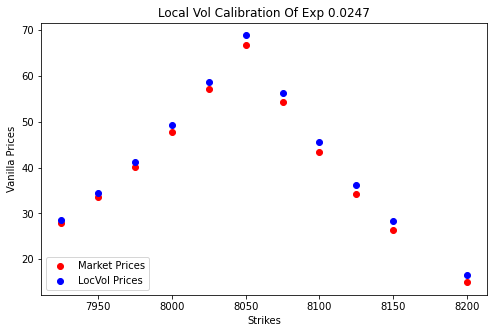

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 4.56%
Number of the Calibration Errors below 5% :  8
Number of the Calibration Errors above 5% :  3
----------------------------------------------------------------------------


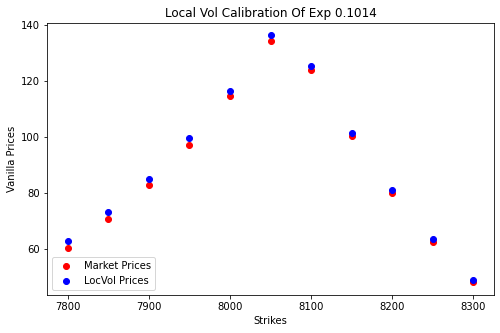

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 2.14%
Number of the Calibration Errors below 5% :  11
Number of the Calibration Errors above 5% :  0
----------------------------------------------------------------------------


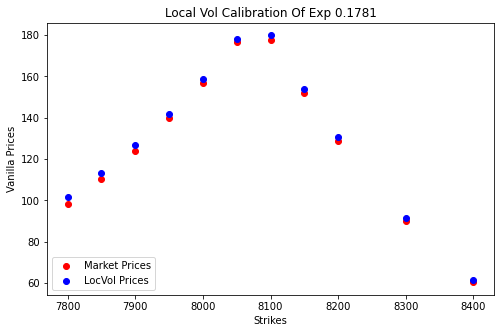

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 1.79%
Number of the Calibration Errors below 5% :  11
Number of the Calibration Errors above 5% :  0
----------------------------------------------------------------------------


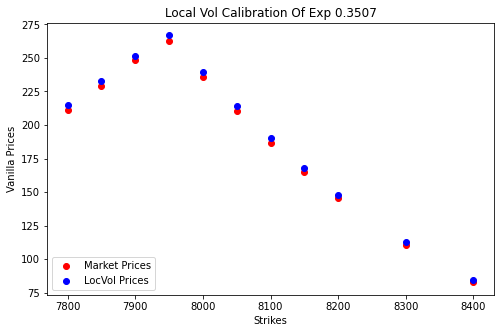

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 1.64%
Number of the Calibration Errors below 5% :  11
Number of the Calibration Errors above 5% :  0
----------------------------------------------------------------------------


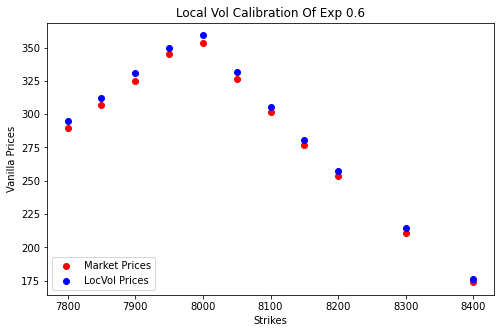

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 1.55%
Number of the Calibration Errors below 5% :  11
Number of the Calibration Errors above 5% :  0
----------------------------------------------------------------------------


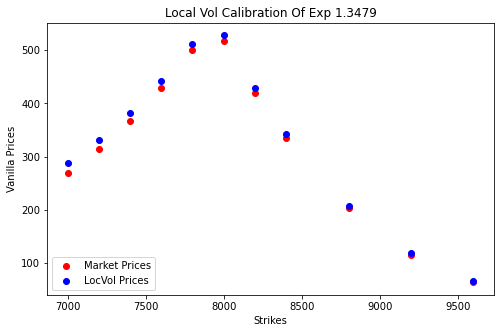

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 3.32%
Number of the Calibration Errors below 5% :  9
Number of the Calibration Errors above 5% :  2
----------------------------------------------------------------------------


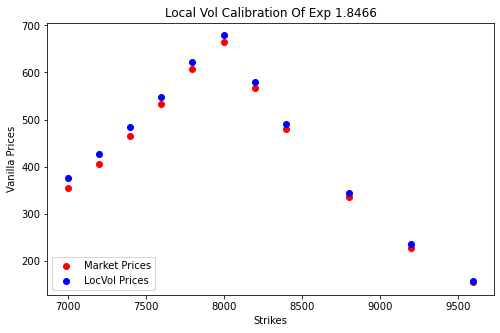

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 3.11%
Number of the Calibration Errors below 5% :  9
Number of the Calibration Errors above 5% :  2
----------------------------------------------------------------------------


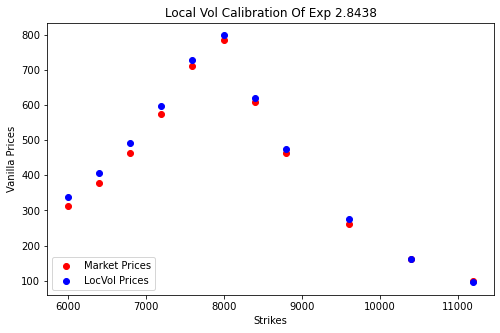

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 3.89%
Number of the Calibration Errors below 5% :  7
Number of the Calibration Errors above 5% :  4
----------------------------------------------------------------------------


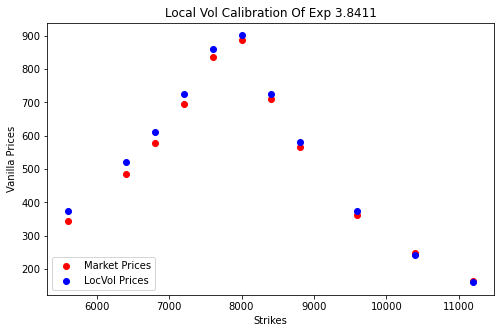

Number of the Calibration Instruments : 11
Average of the Calibration Errors : 3.99%
Number of the Calibration Errors below 5% :  8
Number of the Calibration Errors above 5% :  3
----------------------------------------------------------------------------


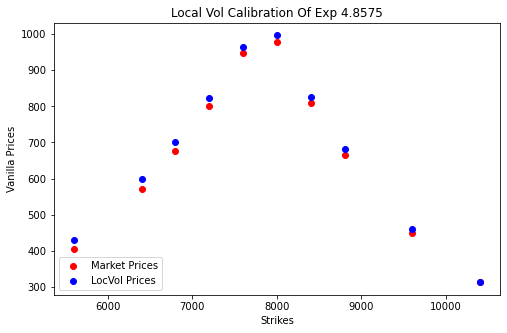

Number of the Calibration Instruments : 10
Average of the Calibration Errors : 2.83%
Number of the Calibration Errors below 5% :  8
Number of the Calibration Errors above 5% :  2
----------------------------------------------------------------------------


In [9]:
plt.rcParams["figure.figsize"] = (8,5)
mc_prices = dict()
for exp in svi_expiries:
    mc_prices_exp = []
    calib_errors_exp = []
    F = forward_curve.calc_forward(exp)
    mc_pricer.set_path(exp)
    n = 0
    for K in market_strikes[exp]:
        mc_prices_exp.append(mc_pricer.vanilla_price(exp, K, F < K))
        calib_errors_exp.append(abs(mc_prices_exp[-1] / market_prices[exp][n] - 1))
        n += 1
    mc_prices[exp] = mc_prices_exp
    
    plt.title("Local Vol Calibration Of Exp " + str(round(exp, 4)))
    plt.ylabel("Vanilla Prices")
    plt.xlabel("Strikes")
    plt.scatter(market_strikes[exp], market_prices[exp], color="red", label="Market Prices")
    plt.scatter(market_strikes[exp], mc_prices_exp, color="blue", label="LocVol Prices")
    plt.legend(loc="lower left")
    plt.show()
    
    print("Number of the Calibration Instruments : " + str(len(calib_errors_exp)))
    print("Average of the Calibration Errors : " + str(round(100 * sum(calib_errors_exp) / len(calib_errors_exp), 2)) + "%")
    print("Number of the Calibration Errors below 5% : ", len([err for err in calib_errors_exp if abs(err) <= 0.05]))
    print("Number of the Calibration Errors above 5% : ", len([err for err in calib_errors_exp if abs(err) > 0.05]))
    print("----------------------------------------------------------------------------")
